## ResNet


In [1]:
import os

import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data import Subset
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose
import torchvision.models as models
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

Subsetを用いて、学習用画像60000枚を学習用50000枚と検証用10000枚に分割

In [3]:
train_size = 50000
train_indices = list(range(0,train_size))
valid_indices = list(range(train_size, len(training_data)))
train_data = Subset(training_data, train_indices)
valid_data = Subset(training_data, valid_indices)

print(len(train_data), len(valid_data))

50000 10000


In [4]:
batch_size = 64

# データローダーの作成
train_dataloader = DataLoader(train_data, batch_size=batch_size)
validation_dataloader = DataLoader(valid_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print("Shape of X [N, C, H, W]: ", X.shape)
    print("Shape of y: ", y.shape, y.dtype)
    break

Shape of X [N, C, H, W]:  torch.Size([64, 1, 28, 28])
Shape of y:  torch.Size([64]) torch.int64


resnetモデル読み込み


モデルgithub:https://github.com/pytorch/vision/blob/main/torchvision/models/resnet.py

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

model = models.resnet18(weights=None, num_classes=10)
model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
model = model.to(device)
print(model)

Using cuda device
ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReL

In [6]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [7]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    epoch_loss = 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        # 損失誤差を計算
        pred = model(X)
        loss = loss_fn(pred, y)
        epoch_loss += loss.item()
        # バックプロパゲーション
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    epoch_loss /= size
    return epoch_loss

In [8]:
def validation(dataloader, model):
    size = len(dataloader.dataset)
    model.eval()
    validation_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            validation_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    validation_loss /= size
    correct /= size
    print(f"Validation Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {validation_loss:>8f} \n")
    return validation_loss

In [9]:
def test(dataloader, model):
    size = len(dataloader.dataset)
    model.eval()
    test_loss, correct = 0, 0
    test_predictions = []
    test_labels = []
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            test_predictions.extend(pred.argmax(1).cpu().tolist())
            test_labels.extend(y.cpu().tolist())
    test_loss /= size
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    results = {"label": test_labels, "prdiction": test_predictions}
    df = pd.DataFrame(results)
    return df


validation損失をもとに最適epochを決定


In [10]:
epochs = 5
min_loss = 1000

model_path = "./model/resnet/"
result_dir = "result/"
os.makedirs(model_path, exist_ok=True)
os.makedirs(result_dir, exist_ok=True)

train_losses = []
validation_losses = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss = train(train_dataloader, model, loss_fn, optimizer)
    train_losses.append(train_loss)
    validation_loss = validation(validation_dataloader, model)
    validation_losses.append(validation_loss)
    if validation_loss < min_loss:
        best_epoch = t+1
        min_loss = validation_loss
    torch.save(model.state_dict(), model_path+"model_"+str(t+1)+".pth")

model.load_state_dict(torch.load(model_path+"model_"+str(best_epoch)+".pth"))
df_label_pred = test(test_dataloader, model)
df_label_pred.to_csv(result_dir+"test_resnet.csv")

print(best_epoch)
print("Done!")

Epoch 1
-------------------------------
loss: 2.735479  [    0/50000]
loss: 1.087451  [ 6400/50000]
loss: 0.698795  [12800/50000]
loss: 0.828625  [19200/50000]
loss: 0.756112  [25600/50000]
loss: 0.642680  [32000/50000]
loss: 0.578876  [38400/50000]
loss: 0.622510  [44800/50000]
Validation Error: 
 Accuracy: 81.2%, Avg loss: 0.008345 

Epoch 2
-------------------------------
loss: 0.412844  [    0/50000]
loss: 0.575054  [ 6400/50000]
loss: 0.324237  [12800/50000]
loss: 0.584431  [19200/50000]
loss: 0.518489  [25600/50000]
loss: 0.490885  [32000/50000]
loss: 0.424721  [38400/50000]
loss: 0.528615  [44800/50000]
Validation Error: 
 Accuracy: 83.5%, Avg loss: 0.007105 

Epoch 3
-------------------------------
loss: 0.290263  [    0/50000]
loss: 0.476076  [ 6400/50000]
loss: 0.228446  [12800/50000]
loss: 0.489747  [19200/50000]
loss: 0.402195  [25600/50000]
loss: 0.424336  [32000/50000]
loss: 0.363050  [38400/50000]
loss: 0.465518  [44800/50000]
Validation Error: 
 Accuracy: 84.5%, Avg los

損失グラフ作成

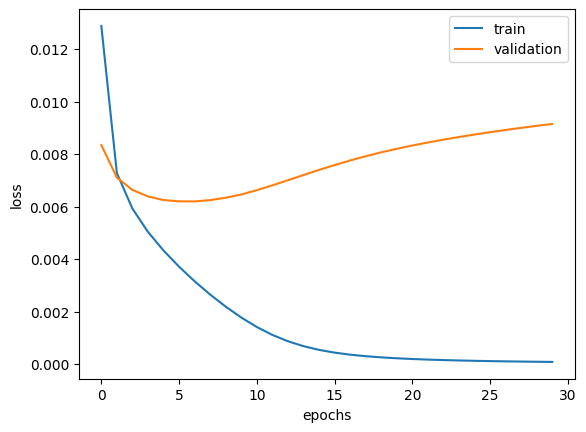

In [11]:
plt.plot(train_losses, label="train")
plt.plot(validation_losses, label="validation")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()
plt.show()


### 予測結果の比較
NN,CNN,ResNetの結果を比較する

In [1]:
df_nn = pd.read_csv("result/test_nn.csv", index_col=0, header=0, names=["label", "pred_nn"])
df_cnn = pd.read_csv("result/test_cnn.csv", index_col=0, header=0, names=["label", "pred_cnn"])
df_cnn.drop(columns=["label"], inplace=True)
df_resnet = pd.read_csv("result/test_cnn.csv", index_col=0, header=0, names=["label", "pred_resnet"])
df_resnet.drop(columns=["label"], inplace=True)

df = pd.concat([df_nn, df_cnn, df_resnet], axis=1)
#nnのみ間違えた例
df_a = df[(df["label"] != df["pred_nn"]) & (df["label"] == df["pred_cnn"]) & (df["label"] == df["pred_resnet"])]
#resnetのみ正解した例
df_b = df[(df["label"] != df["pred_nn"]) & (df["label"] != df["pred_cnn"]) & (df["label"] == df["pred_resnet"])]


NameError: name 'pd' is not defined

label          4
pred_nn        6
pred_cnn       4
pred_resnet    4
Name: 6, dtype: int64


Text(0.5, 1.0, 'Label: 4')

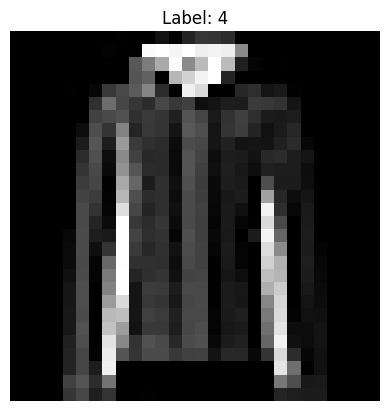

In [13]:
index_a = df_a.index[0]
print(df_a.iloc[0])
image, label = test_data[index_a]
plt.imshow(image.squeeze().numpy(), cmap="gray")
plt.axis("off")
plt.title("Label: {}".format(label))


In [14]:
index_b = df_b.index[0]
print(df_b.iloc[0])
image, label = test_data[index_b]
plt.imshow(image.squeeze().numpy(), cmap="gray")
plt.axis("off")
plt.title("Label: {}".format(label))


IndexError: index 0 is out of bounds for axis 0 with size 0